In [18]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure plots appear in notebook
%matplotlib inline


In [19]:
import os
os.makedirs('/content/outputs', exist_ok=True)

In [20]:
# Step 2: Load datasets
trader_df = pd.read_csv('/content/historical_data.csv', low_memory=False)
sentiment_df = pd.read_csv('/content/fear_greed_index.csv')

In [21]:
# Step 3: Quick overview
print("Trader Data:")
print(trader_df.head())
print("\nFear/Greed Index:")
print(sentiment_df.head())

Trader Data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash  \
0         0.0  0xec0945

In [22]:
# Step 4: Check column names and rename if needed
print("\nSentiment Columns:", sentiment_df.columns)


Sentiment Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [23]:
print(trader_df.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [24]:
# Trader timestamp is in Unix milliseconds
trader_df['date'] = pd.to_datetime(trader_df['Timestamp'], unit='ms').dt.date

# Sentiment date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Rename sentiment classification
sentiment_df.rename(columns={'classification':'Classification'}, inplace=True)

In [25]:
# Fill missing values safely
trader_df = trader_df.fillna(0)
sentiment_df['Classification'] = sentiment_df['Classification'].fillna('Neutral')

# Drop duplicates safely
trader_df = trader_df.drop_duplicates()
sentiment_df = sentiment_df.drop_duplicates()

# Step 4: Merge datasets
# =====================================
merged_df = pd.merge(trader_df, sentiment_df[['date','Classification']], on='date', how='left')

# Drop rows with missing Classification for plotting
merged_plot_df = merged_df.dropna(subset=['Classification'])

In [26]:
print(merged_df['Closed PnL'].dtype)

float64


In [27]:
print(merged_df['Classification'].value_counts())

Classification
Fear             22003
Extreme Greed     6935
Greed             6546
Neutral           3207
Name: count, dtype: int64


In [28]:
print(merged_plot_df.columns.tolist())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'Classification']


In [29]:
merged_plot_df = merged_df.dropna(subset=['Classification']).copy()  # Drop rows with missing Classification

merged_plot_df.rename(columns={
    'Closed PnL':'Closed_PnL',
    'Size Tokens':'Size_Tokens'
}, inplace=True)

In [30]:
merged_plot_df['Closed_PnL'] = pd.to_numeric(merged_plot_df['Closed_PnL'], errors='coerce').fillna(0)
merged_plot_df['Size_Tokens'] = pd.to_numeric(merged_plot_df['Size_Tokens'], errors='coerce').fillna(0)

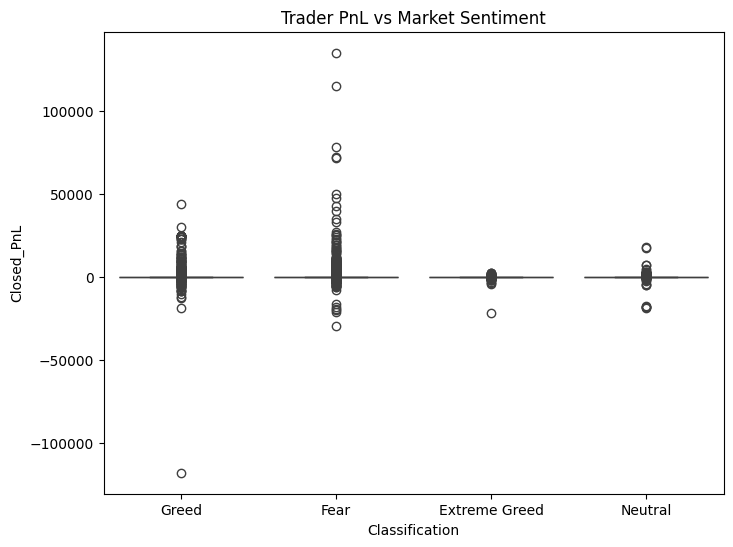

In [31]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Classification', y='Closed_PnL', data=merged_plot_df)
plt.title('Trader PnL vs Market Sentiment')
plt.savefig('/content/outputs/pnl_vs_sentiment.png')
plt.show()

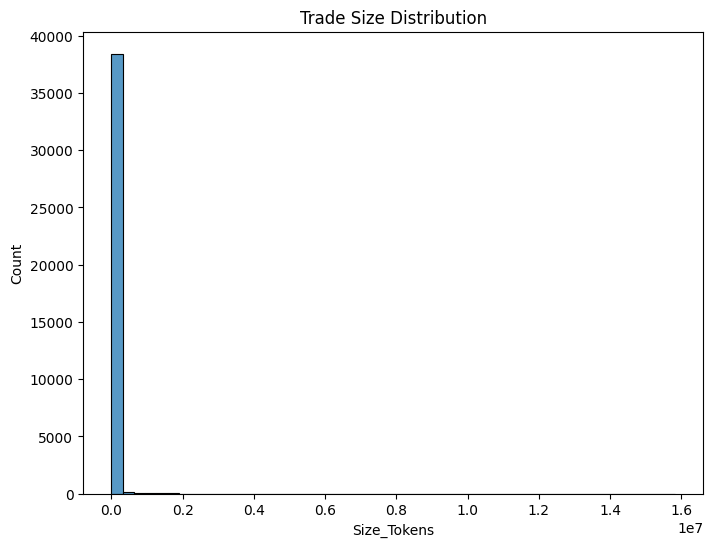

In [32]:
plt.figure(figsize=(8,6))
sns.histplot(merged_plot_df['Size_Tokens'], bins=50)
plt.title('Trade Size Distribution')
plt.savefig('/content/outputs/trade_size_hist.png')
plt.show()

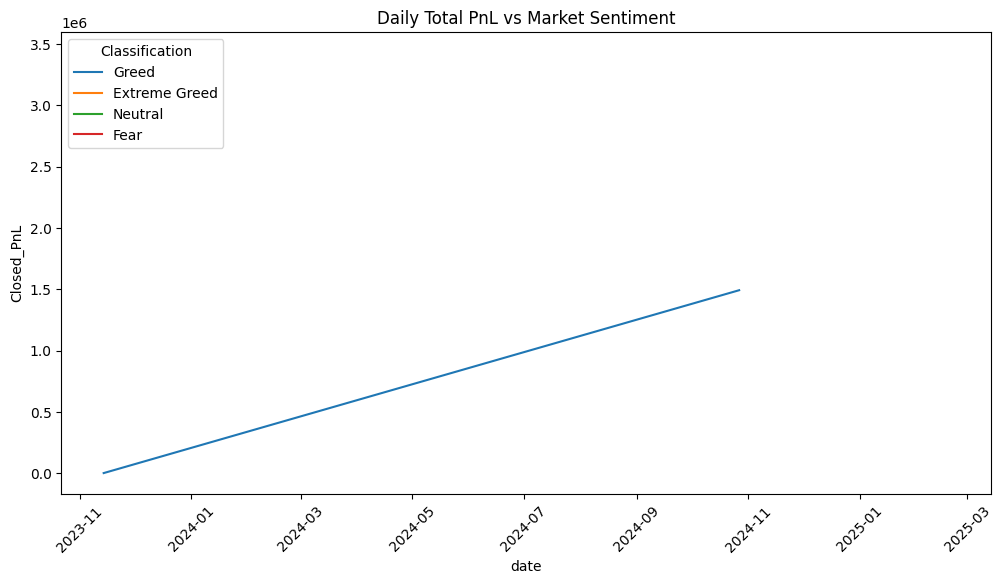

In [33]:
daily_pnl = merged_plot_df.groupby('date')['Closed_PnL'].sum().reset_index()
daily_sentiment = merged_plot_df[['date','Classification']].drop_duplicates()
daily_merged = pd.merge(daily_pnl, daily_sentiment, on='date', how='left')

plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='Closed_PnL', hue='Classification', data=daily_merged)
plt.title('Daily Total PnL vs Market Sentiment')
plt.xticks(rotation=45)
plt.savefig('/content/outputs/daily_pnl_vs_sentiment.png')
plt.show()


In [34]:
pnl_by_sentiment = merged_plot_df.groupby('Classification')['Closed_PnL'].mean()
size_by_sentiment = merged_plot_df.groupby('Classification')['Size_Tokens'].sum()

print("\nAverage PnL by Sentiment:\n", pnl_by_sentiment)
print("\nTotal Trade Size by Sentiment:\n", size_by_sentiment)



Average PnL by Sentiment:
 Classification
Extreme Greed     26.320044
Fear             155.762960
Greed            227.985056
Neutral           56.800214
Name: Closed_PnL, dtype: float64

Total Trade Size by Sentiment:
 Classification
Extreme Greed    3.392996e+08
Fear             2.700890e+08
Greed            1.770770e+07
Neutral          7.426381e+06
Name: Size_Tokens, dtype: float64


In [34]:
from google.colab import files
files.download('/content/outputs/pnl_vs_sentiment.png')
files.download('/content/outputs/trade_size_hist.png')
files.download('/content/outputs/daily_pnl_vs_sentiment.png')
